# Startup

In [37]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/50_Startups.csv')
df.rename(columns = {'R&D Spend':'RD_spend', 'Marketing Spend':'MarketingSpend'}, inplace = True)
df.head(5)

,RD_spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [38]:
df.columns

Index(['RD_spend', 'Administration', 'MarketingSpend', 'State', 'Profit'], dtype='object')

In [39]:
df.corr()

,RD_spend,Administration,MarketingSpend,Profit
RD_spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
MarketingSpend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


In [40]:
# checking missing values
df.isna().sum()

RD_spend          0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

## scatterplot 

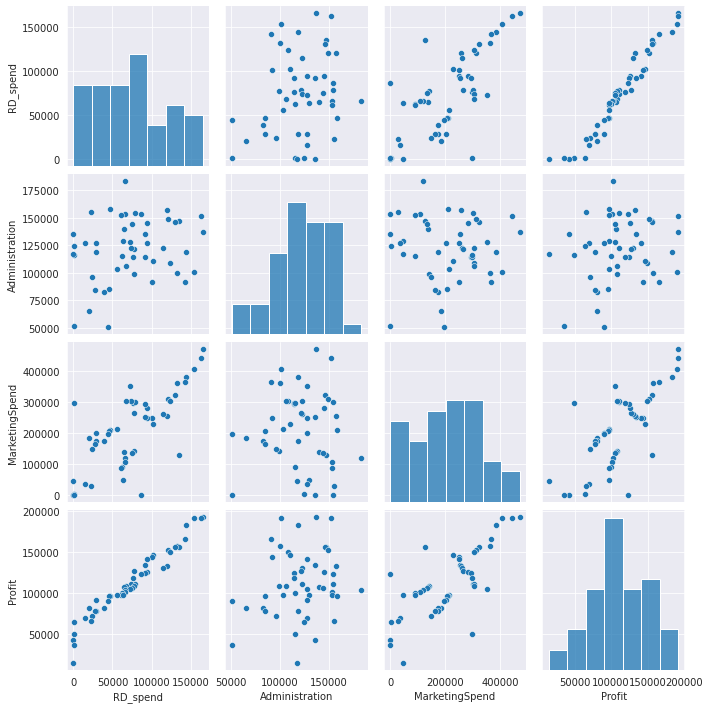

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style(style='darkgrid')
sns.pairplot(df)

## Preparing model

In [42]:
#Build model
import statsmodels.formula.api as smf 
model = smf.ols('Profit~RD_spend+Administration+MarketingSpend',data=df).fit()

In [43]:
model.tvalues

Intercept          7.626218
RD_spend          17.846374
Administration    -0.525507
MarketingSpend     1.655077
dtype: float64

In [44]:
model.pvalues

Intercept         1.057379e-09
RD_spend          2.634968e-22
Administration    6.017551e-01
MarketingSpend    1.047168e-01
dtype: float64

In [82]:
(model.rsquared, model.rsquared_adj, model.aic)

(0.9507459940683246, 0.9475337762901719, 1058.7714985998055)

## Individual SLR model

In [46]:
admin_model = smf.ols('Profit~Administration',data=df).fit()
admin_model.pvalues

Intercept         0.003824
Administration    0.162217
dtype: float64

In [47]:
market_model = smf.ols('Profit~MarketingSpend',data=df).fit()
market_model.pvalues

Intercept         4.294735e-10
MarketingSpend    4.381073e-10
dtype: float64

In [48]:
test_model = smf.ols('Profit~MarketingSpend+Administration',data=df).fit()
test_model.pvalues

Intercept         2.589341e-01
MarketingSpend    9.727245e-11
Administration    1.729198e-02
dtype: float64

## Calculating VIF

In [49]:
profit = smf.ols('Profit~MarketingSpend+Administration+RD_spend', data = df).fit().rsquared
vif_profit = 1/(1-profit)

market = smf.ols('MarketingSpend~Profit+Administration+RD_spend', data = df).fit().rsquared
vif_market = 1/(1-market)

admin_ = smf.ols('Administration~MarketingSpend+Profit+RD_spend', data = df).fit().rsquared
vif_admin = 1/(1-admin_)

rd = smf.ols('RD_spend~MarketingSpend+Administration+Profit', data = df).fit().rsquared
vif_rd = 1/(1-rd)

points = {'var' : ['Profit', 'market', 'admin', 'rd'], 'vif':[vif_profit, vif_market, vif_admin, vif_rd]}
vif_frame = pd.DataFrame(points)
vif_frame

,var,vif
0,Profit,20.302917
1,market,2.465332
2,admin,1.182146
3,rd,19.563001


## Residual analysis

## Normality of Residue qq-plot

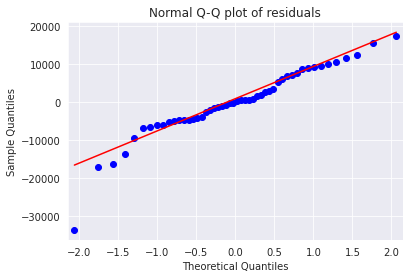

In [50]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

qqplot=sm.qqplot(model.resid,line='q') # line = 45 to draw the diagnoal line
plt.title("Normal Q-Q plot of residuals")
plt.show()

## Homoscedasticity residual plot

In [51]:
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

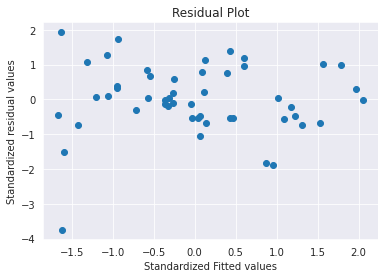

In [52]:
plt.scatter(get_standardized_values(model.fittedvalues),
            get_standardized_values(model.resid))

plt.title('Residual Plot')
plt.xlabel('Standardized Fitted values')
plt.ylabel('Standardized residual values')
plt.show()

## Residual vs Regressors

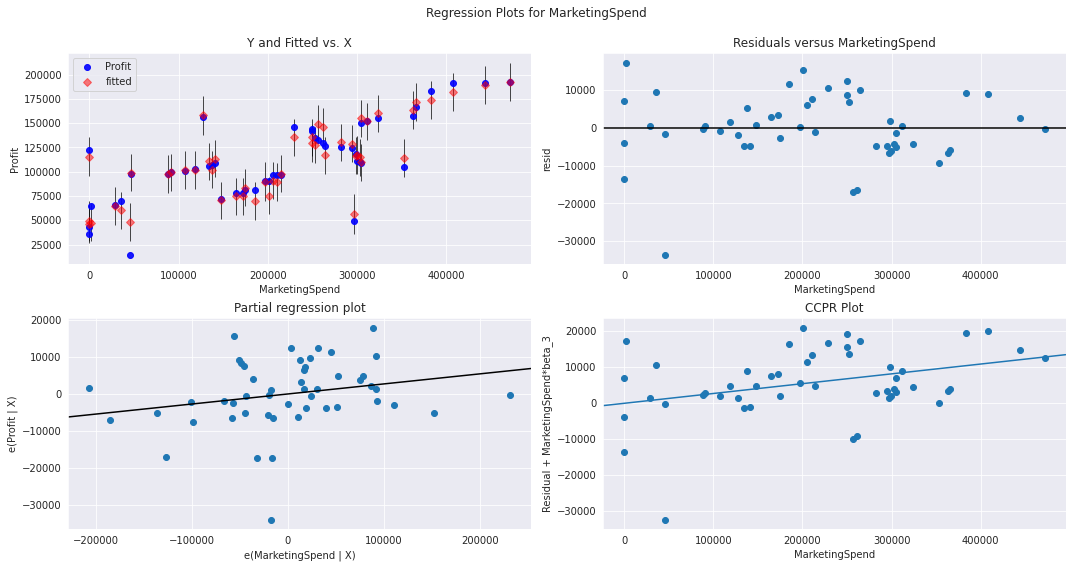

In [53]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "MarketingSpend", fig=fig)
plt.show()

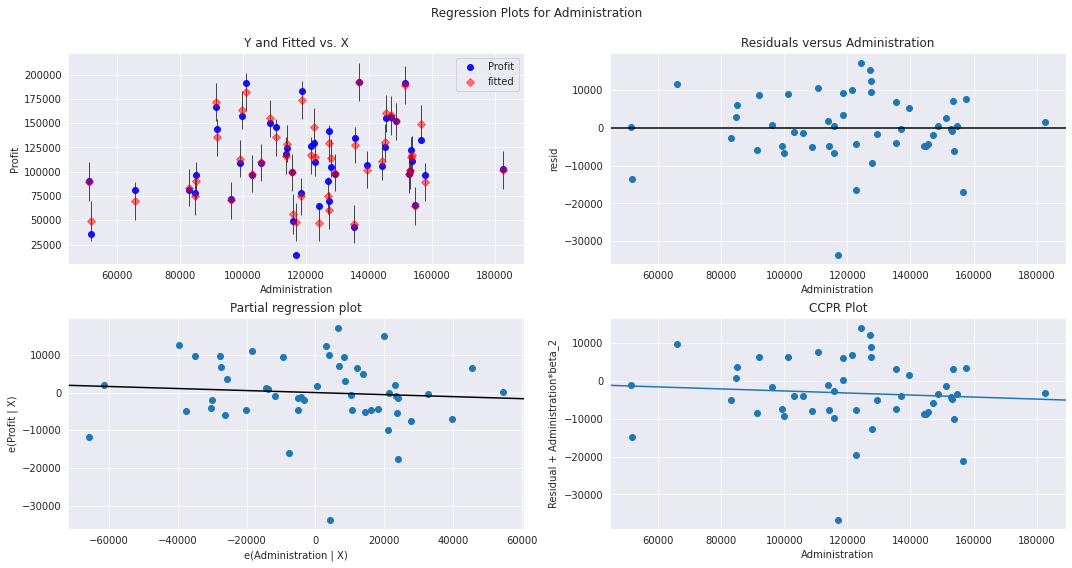

In [54]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Administration", fig=fig)
plt.show()

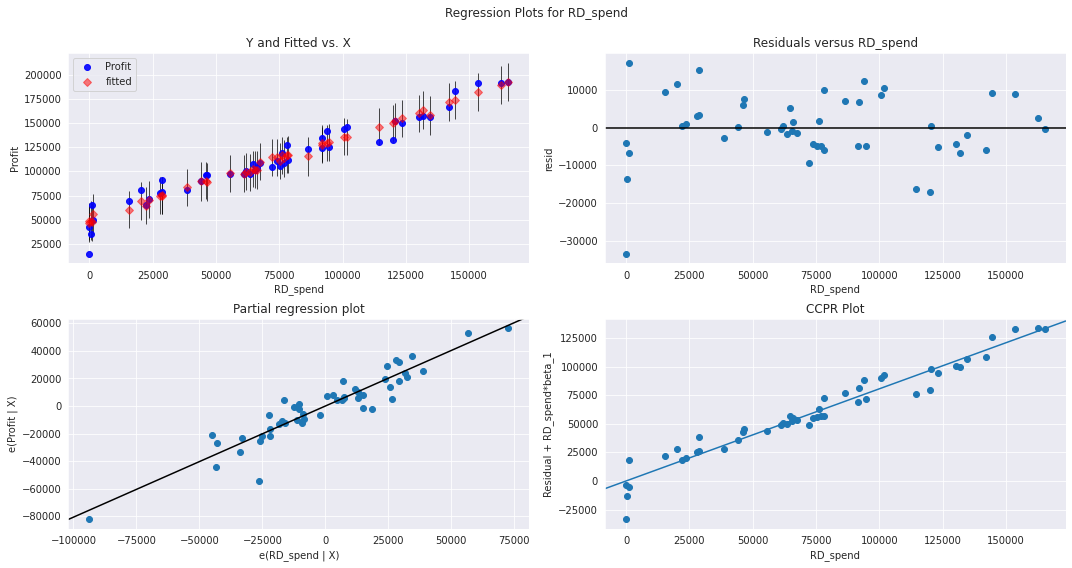

In [55]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "RD_spend", fig=fig)
plt.show()

## Cooks distance

In [56]:
model_influence = model.get_influence()
(c, _) = model_influence.cooks_distance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


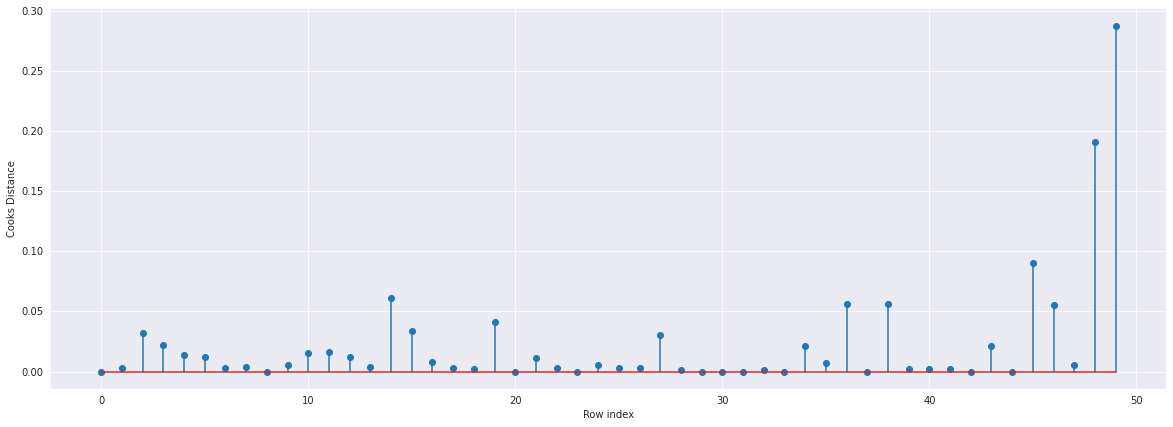

In [57]:
#Plot the influencers values using stem plot
fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(df)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

In [58]:
#index and value of influencer where c is more than .5
(np.argmax(c),np.max(c))

(49, 0.2880822927543272)

## High influence points

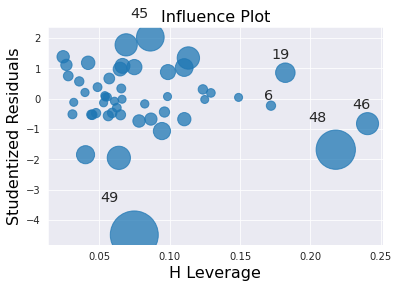

In [59]:
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(model)
plt.show()

In [60]:
k = df.shape[1] # gives column count
n = df.shape[0]
leverage_cutoff = 3*((k + 1)/n)

In [61]:
df[df.index.isin([49, 48])]

,RD_spend,Administration,MarketingSpend,State,Profit
48,542.05,51743.15,0.00,New York,35673.41
49,0.00,116983.80,45173.06,California,14681.40


In [62]:
df.head(3)

,RD_spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39


## Improving model

In [73]:
df_new = pd.read_csv('/content/50_Startups.csv')
df_new.rename(columns = {'R&D Spend':'RD_spend', 'Marketing Spend':'MarketingSpend'}, inplace = True)

In [74]:
#Discard the data points which are influencers and reasign the row number (reset_index())
df_fmv=df_new.drop(df_new.index[[48,49]],axis=0).reset_index()

In [75]:
#Drop the original index
df_fmv=df_fmv.drop(['index'],axis=1)

## Final model

In [76]:
final_ml_V= smf.ols('Profit~RD_spend+MarketingSpend+Administration',data = df_fmv).fit()

In [77]:
(final_ml_V.rsquared,final_ml_V.aic)

(0.9626766170294073, 994.6690439260116)

## Predicting a new data

In [78]:
new_data = pd.DataFrame({'MarketingSpend':558426, 'Administration':958655, 'RD_spend':698321}, index = [1])
final_ml_V.predict(new_data)

1    559124.292765
dtype: float64

In [81]:
# model accuracy
(final_ml_V.rsquared, final_ml_V.rsquared_adj, final_ml_V.aic)

(0.9626766170294073, 0.960131840917776, 994.6690439260116)